<a href="https://colab.research.google.com/github/Shirley31415926/API_heatwave/blob/main/04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Data acquisition

To assess seasonal temperature anomalies, we first extracted all available temperature data for the months of June to September spanning the years 2018 to 2025. This dataset provides a five-year historical context for evaluating interannual variability in summer temperatures.

Subsequently, we computed the multi-year average temperature for each day across the five-year period from 2018 to 2024. These averages serve as a baseline reference. To identify temperature deviations, we calculated the daily temperature differences between: 2023 observations and the 2018–2024 average, and 2024 observations and the 2018–2024 average.

This resulted in two sets of daily anomaly values, capturing whether temperatures in 2023 and 2024 were above or below the multi-year norm. These anomalies enable us to evaluate the extent and direction of temperature departures during recent summers.

Load the API in the Climate Data Store using the following links: https://cds.climate.copernicus.eu/profile?tab=profile https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+macOS

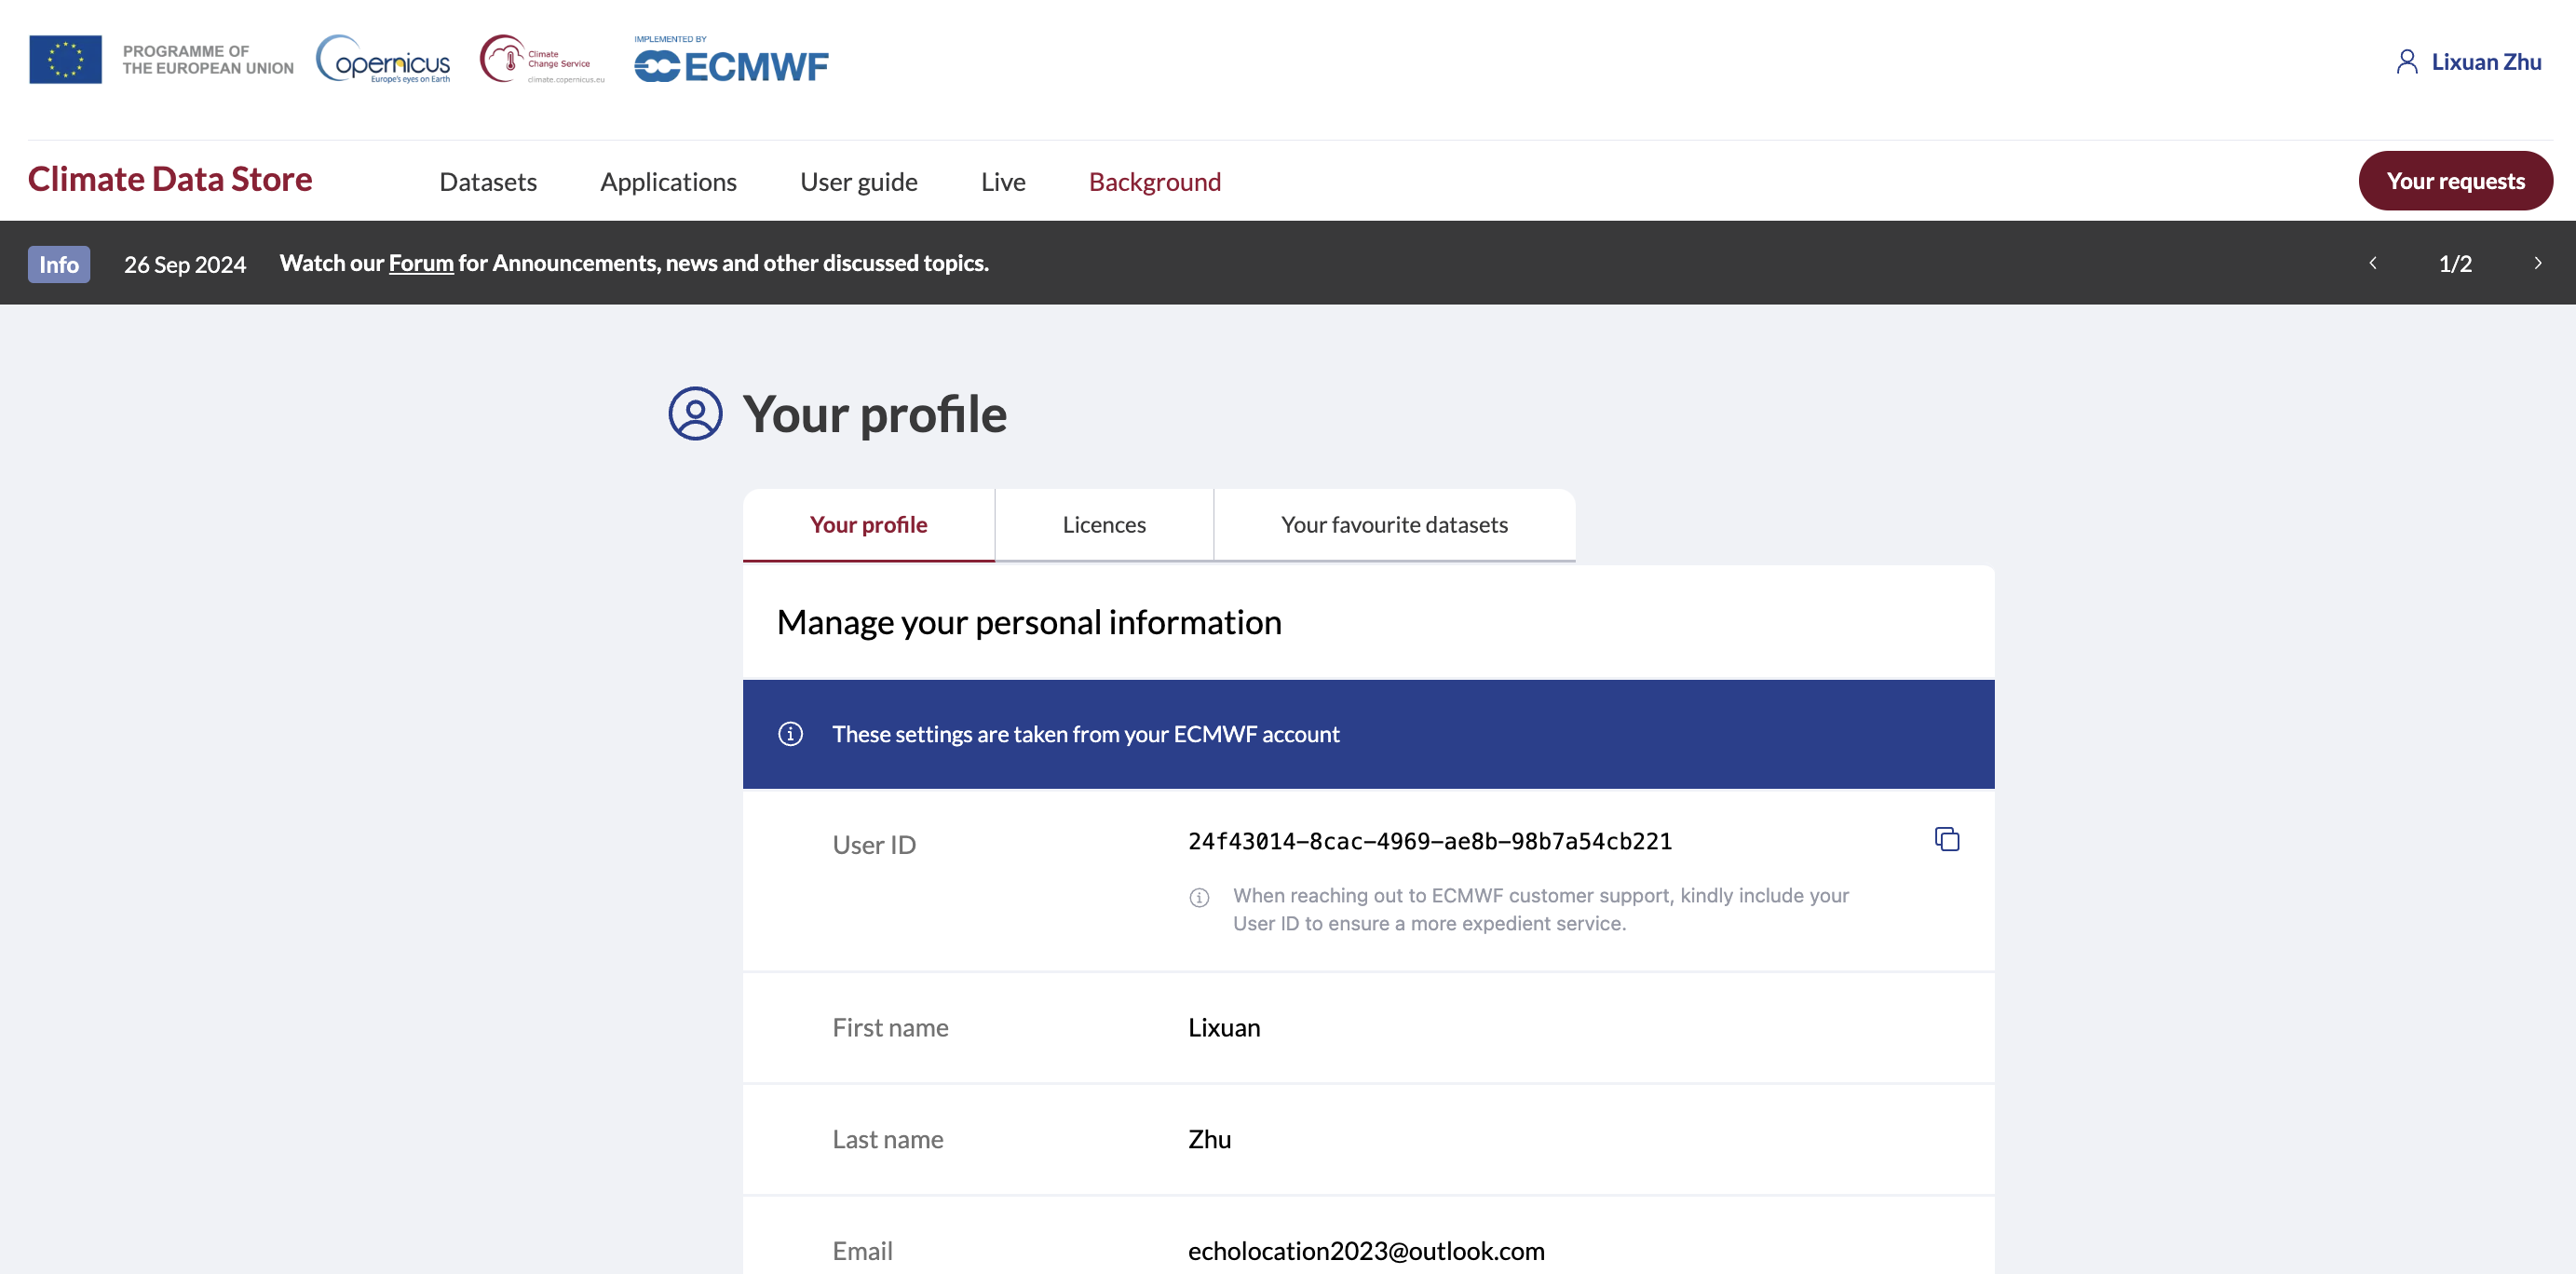

We used the ERA5 post-processed daily statistics on single levels from 1940 to present dataset to download 2m temperature (which reflects apparent temperature) and 2m dewpoint temperature (which can serve as an indicator of humidity) for the years 2018 to 2024.
https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=overview

We obtained data from the ERA5 reanalysis dataset, specifically focusing on the 2m dewpoint temperature and 2m temperature variables. The data covers the months of June, July, August, and September from 2018 to 2024, with a daily maximum statistic provided in UTC+00:00 time zone. The data is available at a 6-hourly frequency and spans a global geographical area (North: 90°, West: -180°, South: 0°, East: 180°).

The downloaded files are in NetCDF format, with the following structure: Dimensions: valid_time: 122 days, from June 1 to September 30；latitude: 361 values, from 90° to 0°；longitude: 1440 values, from -180° to 179.75°
Data variable: t2m and d2m.

In [ ]:
!pip install cdsapi --quiet

In [ ]:
!pip install xarray netCDF4 pandas
import xarray as xr
import pandas as pd
file_path = '/content/2m_temperature_0_daily-max.nc'
ds = xr.open_dataset(file_path)
print(ds)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.1 MB/s eta 0:00:00
<xarray.Dataset> Size: 254MB
Dimensions:     (valid_time: 122, latitude: 361, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 3kB 90.0 89.75 89.5 89.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * valid_time  (valid_time) datetime64[ns] 976B 2018-06-01 ... 2018-09-30
Data variables:
    t2m         (valid_time, latitude, longitude) float32 254MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-08T22:39 GRIB to CDM+CF via cfgrib-0.9.1...


Since the data obtained from ERA5 includes all grid points across the Northern Hemisphere, we applied a land mask to ensure the accuracy of our analysis. This allows us to extract only the data points located over land areas.The land mask data was also obtained from ERA5 (in the folder, it is named cdsapirc).

In [ ]:
import xarray as xr

t2m_ds = xr.open_dataset("/content/2m_temperature_0_daily-max2024.nc")
lsm_ds = xr.open_dataset("/content/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc")

t2m = t2m_ds['t2m']
lsm = lsm_ds['lsm']

# 1. Use the static land-sea mask from the first time step (assuming LSM doesn't change over time)
lsm_static = lsm.isel(time=0)

# 2. Extract variables
t2m = t2m_ds['t2m']
lsm = lsm_ds['lsm']  # LSM values are typically 0 (water) and 1 (land)

# 4. Filter for land surface temperature (keep only land grid cells)
t2m_land = t2m.where(lsm == 1)

t2m_land.to_netcdf("t2m_land_only.nc")

<xarray.Dataset> Size: 32MB
Dimensions:     (latitude: 180, longitude: 360, valid_time: 122)
Coordinates:
  * latitude    (latitude) float64 1kB 90.0 89.5 89.0 88.5 ... 2.0 1.5 1.0 0.5
  * longitude   (longitude) float64 3kB 0.0 0.5 1.0 1.5 ... 178.5 179.0 179.5
  * valid_time  (valid_time) datetime64[ns] 976B 2024-06-01 ... 2024-09-30
    number      int64 8B ...
    time        datetime64[ns] 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 32MB ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

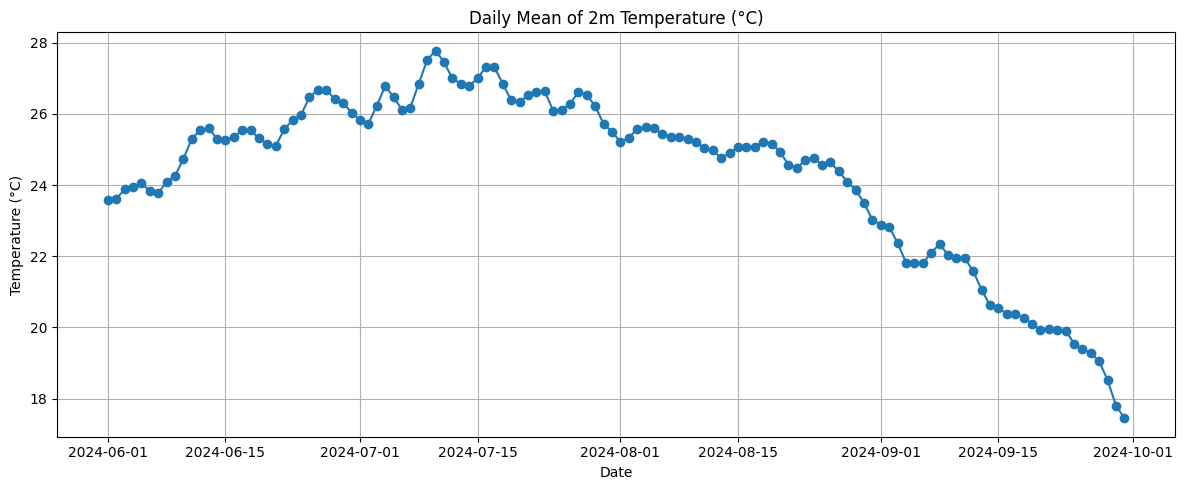

In [ ]:
!pip install xarray netCDF4 pandas
import xarray as xr
import pandas as pd

file_path = '/content/2024t2m_land_only.nc'

ds = xr.open_dataset(file_path)
print(ds)
daily_avg_t2m = ds['t2m'].mean(dim=['latitude', 'longitude'])
daily_avg_t2m_C = daily_avg_t2m - 273.15

df_daily_avg = daily_avg_t2m_C.to_dataframe(name='t2m_C').reset_index()
df_daily_avg.head()
df_daily_avg.to_csv('daily_mean_2m_temperature2024land.csv', index=False)
from google.colab import files
files.download('daily_mean_2m_temperature2024land.csv')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_daily_avg['valid_time'], df_daily_avg['t2m_C'], marker='o')
plt.title('Daily Mean of 2m Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


The method provided above was used to read the data for 2024. In addition, the same approach was applied to obtain and process data with the land mask for the years 2018, 2019, 2020, 2021, 2022, and 2023.

# 2.Temperature data

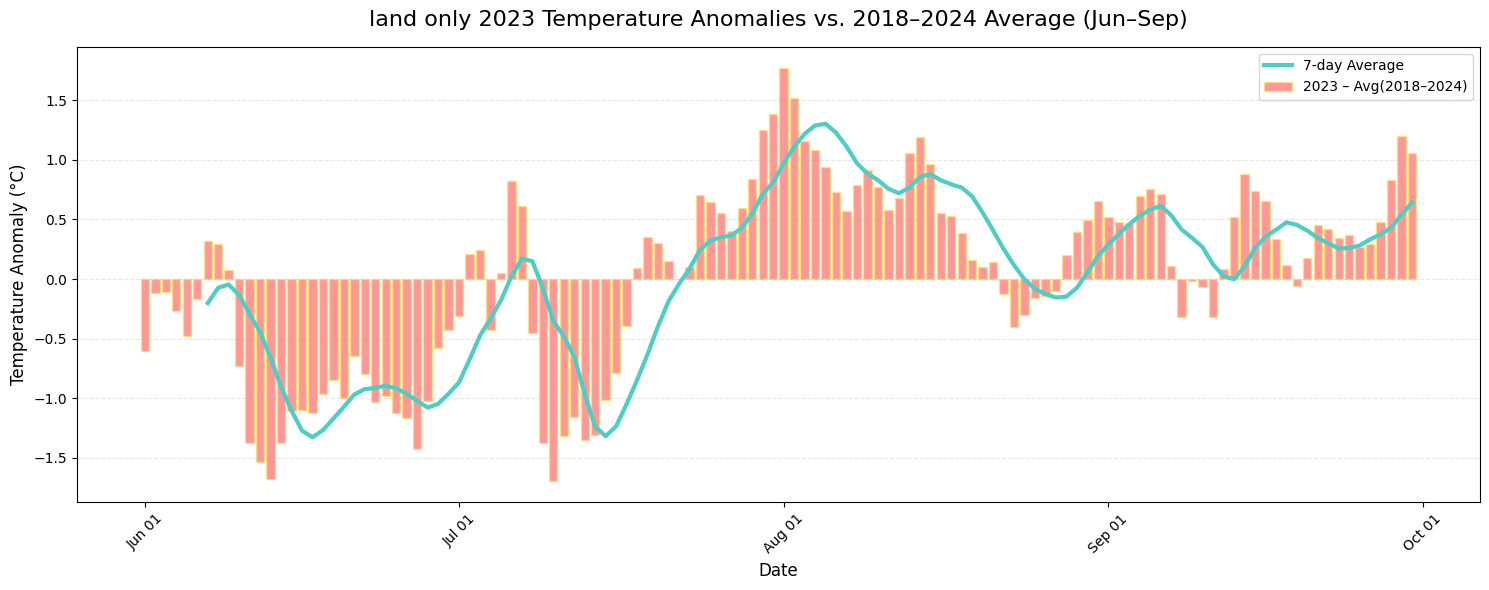

In [ ]:
#2023 2m temperature data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_temp = pd.read_csv("/content/lsm2023.csv")
df_temp.columns = ['Month-Day', 'Anomaly']
df_temp['Anomaly'] = pd.to_numeric(df_temp['Anomaly'].astype(str).str.strip(), errors='coerce')
df_temp['Date'] = pd.to_datetime("2023-" + df_temp['Month-Day'], format='%Y-%m-%d')
df_temp = df_temp.sort_values('Date')
df_temp['7day_avg'] = df_temp['Anomaly'].rolling(window=7).mean()
plt.figure(figsize=(15, 6))

# 🔴 Bar chart (daily anomalies)
plt.bar(df_temp['Date'], df_temp['Anomaly'],
        color='#FF6B6B', edgecolor='#FFE66D', alpha=0.7,
        width=0.8, label='2023 – Avg(2018–2024)')

# 🟢 7-day moving average line
plt.plot(df_temp['Date'], df_temp['7day_avg'],
         color='#4ECDC4', linewidth=3, label='7-day Average')

# Set title and axes labels
plt.title("Land Only 2023 Temperature Anomalies vs. 2018–2024 Average (Jun–Sep)", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature Anomaly (°C)", fontsize=12)

# Set grid and date formatting
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Legend & layout
plt.legend()
plt.tight_layout()
plt.show()

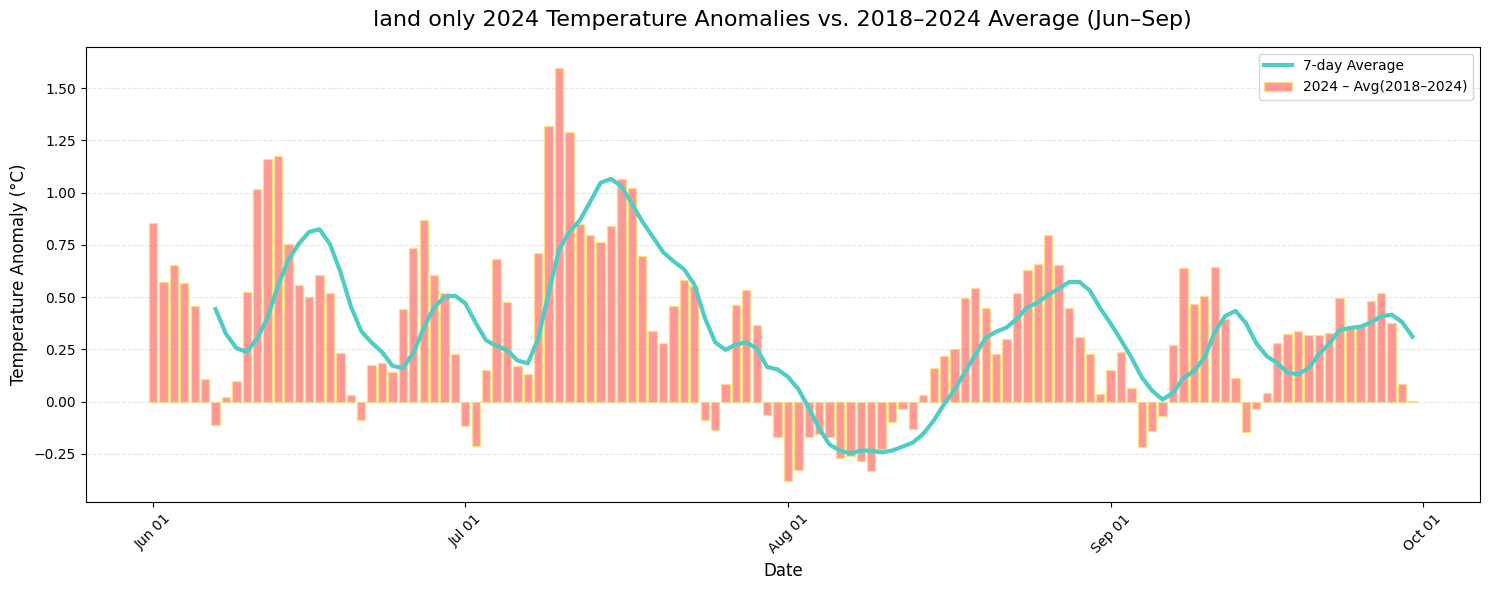

In [ ]:
#2024 2m temperature data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
df_temp = pd.read_csv("/content/lsm2024.csv")  # Update with your file path
df_temp.columns = ['Month-Day', 'Anomaly']
df_temp['Anomaly'] = pd.to_numeric(df_temp['Anomaly'].astype(str).str.strip(), errors='coerce')
df_temp['Date'] = pd.to_datetime("2024-" + df_temp['Month-Day'], format='%Y-%m-%d')
df_temp = df_temp.sort_values('Date')
df_temp['7day_avg'] = df_temp['Anomaly'].rolling(window=7).mean()

# Start plotting
plt.figure(figsize=(15, 6))

# 🔴 Bar chart (daily anomalies)
plt.bar(df_temp['Date'], df_temp['Anomaly'],
        color='#FF6B6B', edgecolor='#FFE66D', alpha=0.7,
        width=0.8, label='2024 – Avg(2018–2024)')

# 🟢 7-day moving average line
plt.plot(df_temp['Date'], df_temp['7day_avg'],
         color='#4ECDC4', linewidth=3, label='7-day Average')

# Set title and axis labels
plt.title("Land Only 2024 Temperature Anomalies vs. 2018–2024 Average (Jun–Sep)", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature Anomaly (°C)", fontsize=12)

# Configure grid and date format
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Legend & layout
plt.legend()
plt.tight_layout()
plt.show()

# 3.Dewpoint temperature data（Humidity）
A higher dewpoint means the air holds more moisture, making it feel more humid. When the dewpoint is high, the air can feel especially muggy or uncomfortable, as sweat doesn't evaporate as easily.

In [ ]:
import xarray as xr
import pandas as pd

# Step 0: Load data
d2m_ds = xr.open_dataset("/content/2m_dewpoint_temperature_stream-oper_daily-max2024.nc")
lsm_ds = xr.open_dataset("/content/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc")

# Step 1: Extract variables
d2m = d2m_ds['d2m']
lsm = lsm_ds['lsm']

# Step 2: Get static land-sea mask (skip this step if lsm has no time dimension)
if "time" in lsm.dims:
    lsm_static = lsm.isel(time=0)
else:
    lsm_static = lsm

# Step 3: Rename coordinates for consistency
lsm_static = lsm_static.rename({'longitude': 'lon', 'latitude': 'lat'})
d2m = d2m.rename({'longitude': 'lon', 'latitude': 'lat'})

# Step 4: Interpolate land-sea mask to match d2m grid
lsm_resampled = lsm_static.interp(
    lat=d2m.lat,
    lon=d2m.lon,
    method="nearest"
)
# Step 5: Create binary mask (1 = land, 0 = ocean)
lsm_binary = (lsm_resampled > 0.5).astype(int)

# Step 6: Broadcast mask to match d2m's 3D shape
lsm_binary_expanded = lsm_binary.broadcast_like(d2m)

# Step 7: Apply mask to retain only land-based dew point temperature
d2m_land = d2m.where(lsm_binary_expanded == 1)

# Step 8: Convert to degrees Celsius
d2m_land_C = d2m_land - 273.15

# Step 9: Calculate daily spatial average (latitude + longitude)
daily_avg = d2m_land_C.mean(dim=["lat", "lon"])

# Step 10: Convert to DataFrame
df = daily_avg.to_dataframe(name="d2m_C").reset_index()

# Step 11: Preview the result
print(df.head())

# Step 12: Optional save to CSV
df.to_csv("2024daily_dewpoint_land_only_C.csv", index=False)

  valid_time  number       time      d2m_C
0 2024-06-01       0 2013-11-29   8.833049
1 2024-06-02       0 2013-11-29   9.109151
2 2024-06-03       0 2013-11-29   9.469548
3 2024-06-04       0 2013-11-29   9.756312
4 2024-06-05       0 2013-11-29  10.235730


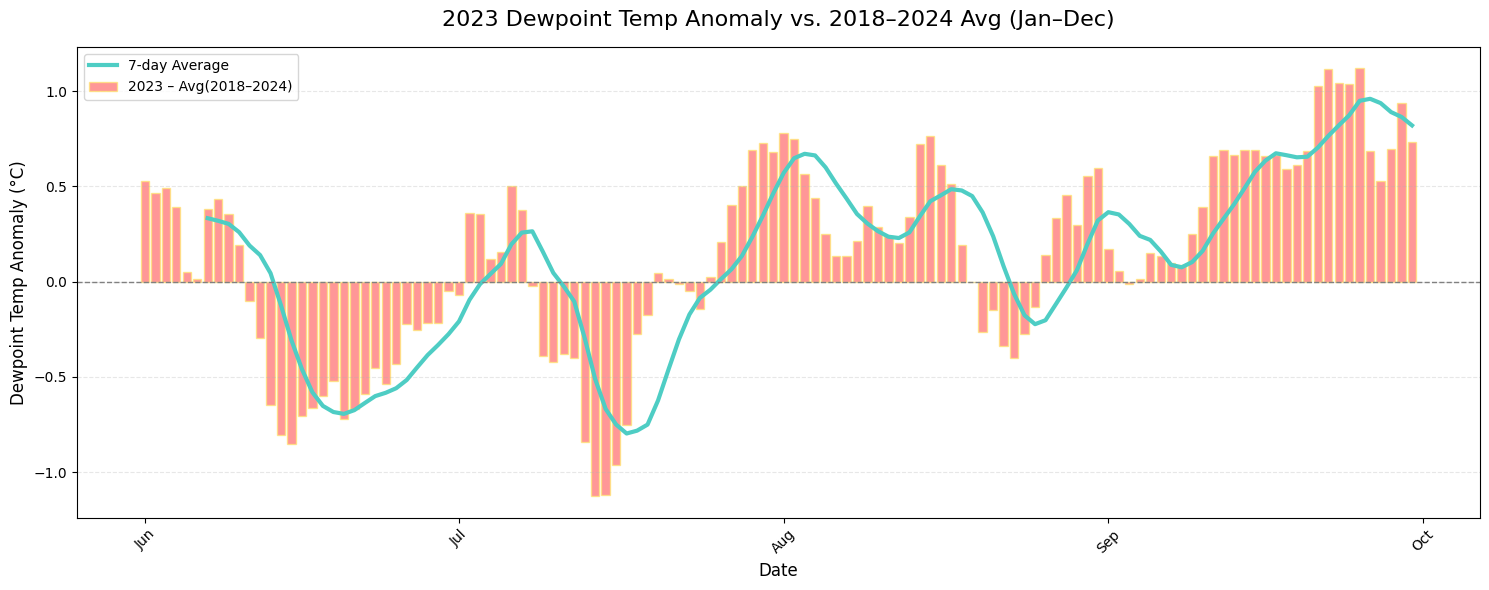

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df = pd.read_csv("/content/2023dewpoint-temperature.csv")
df.columns = ['Month-Day', 'Anomaly']

# Clean data
df['Anomaly'] = pd.to_numeric(df['Anomaly'].astype(str).str.strip(), errors='coerce')
df['Date'] = pd.to_datetime("2023-" + df['Month-Day'], format='%Y-%m-%d')
df = df.sort_values('Date')
df['7day_avg'] = df['Anomaly'].rolling(window=7).mean()

# Start plotting
plt.figure(figsize=(15, 6))

# 🔴 Bar chart (daily anomalies)
plt.bar(df['Date'], df['Anomaly'],
        color='#FF6B6B', edgecolor='#FFE66D', alpha=0.7,
        width=0.8, label='2023 – Avg(2018–2024)')

# 🟢 7-day moving average line
plt.plot(df['Date'], df['7day_avg'],
         color='#4ECDC4', linewidth=3, label='7-day Average')

# Add zero line
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Set title and axis labels
plt.title("2023 Dewpoint Temperature Anomaly vs. 2018–2024 Average (Jan–Dec)", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Dewpoint Temperature Anomaly (°C)", fontsize=12)
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

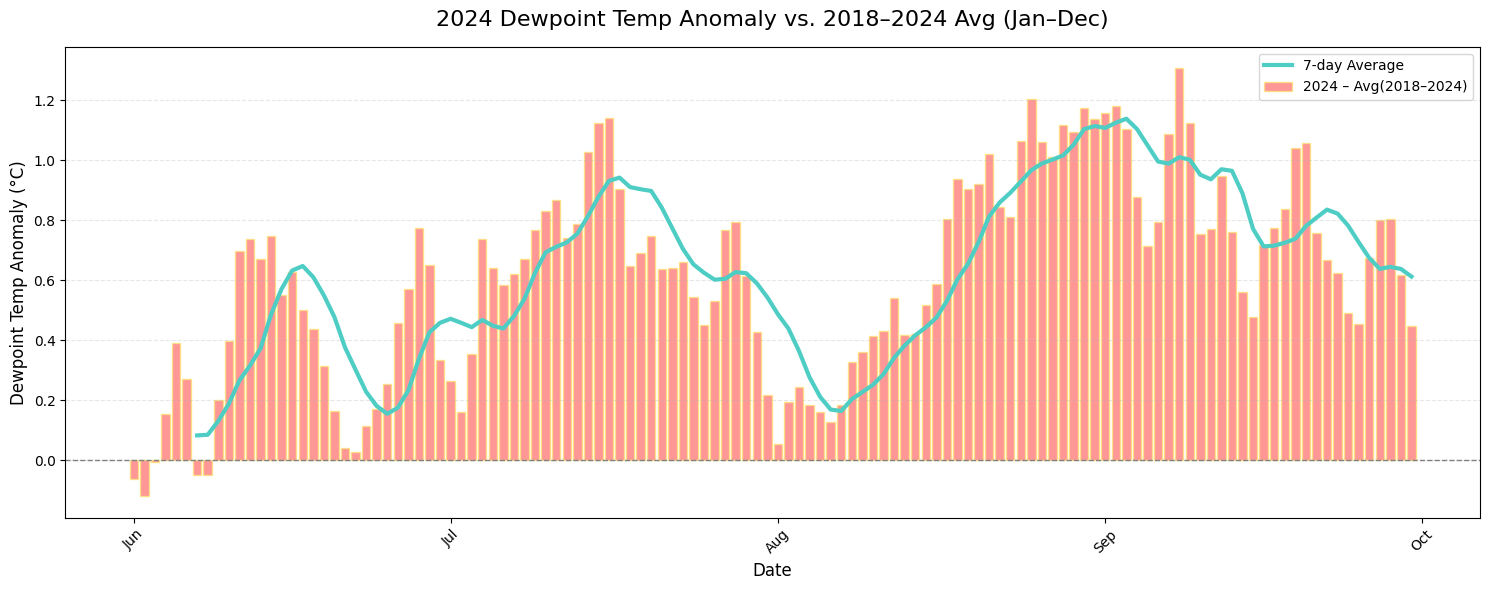

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("/content/2024 dewpoint-temperature.csv")
df.columns = ['Month-Day', 'Anomaly']

# Clean data
df['Anomaly'] = pd.to_numeric(df['Anomaly'].astype(str).str.strip(), errors='coerce')
df['Date'] = pd.to_datetime("2024-" + df['Month-Day'], format='%Y-%m-%d')
df = df.sort_values('Date')
df['7day_avg'] = df['Anomaly'].rolling(window=7).mean()

# Start plotting
plt.figure(figsize=(15, 6))

# 🔴 Bar chart (daily anomalies)
plt.bar(df['Date'], df['Anomaly'],
        color='#FF6B6B', edgecolor='#FFE66D', alpha=0.7,
        width=0.8, label='2024 – Avg(2018–2024)')

# 🟢 7-day moving average line
plt.plot(df['Date'], df['7day_avg'],
         color='#4ECDC4', linewidth=3, label='7-day Average')

# Add zero line
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title("2024 Dewpoint Temperature Anomaly vs. 2018–2024 Average (Jan–Dec)", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Dewpoint Temperature Anomaly (°C)", fontsize=12)
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Analyzing the Relationship Between Temperature Anomalies and Social Media Response

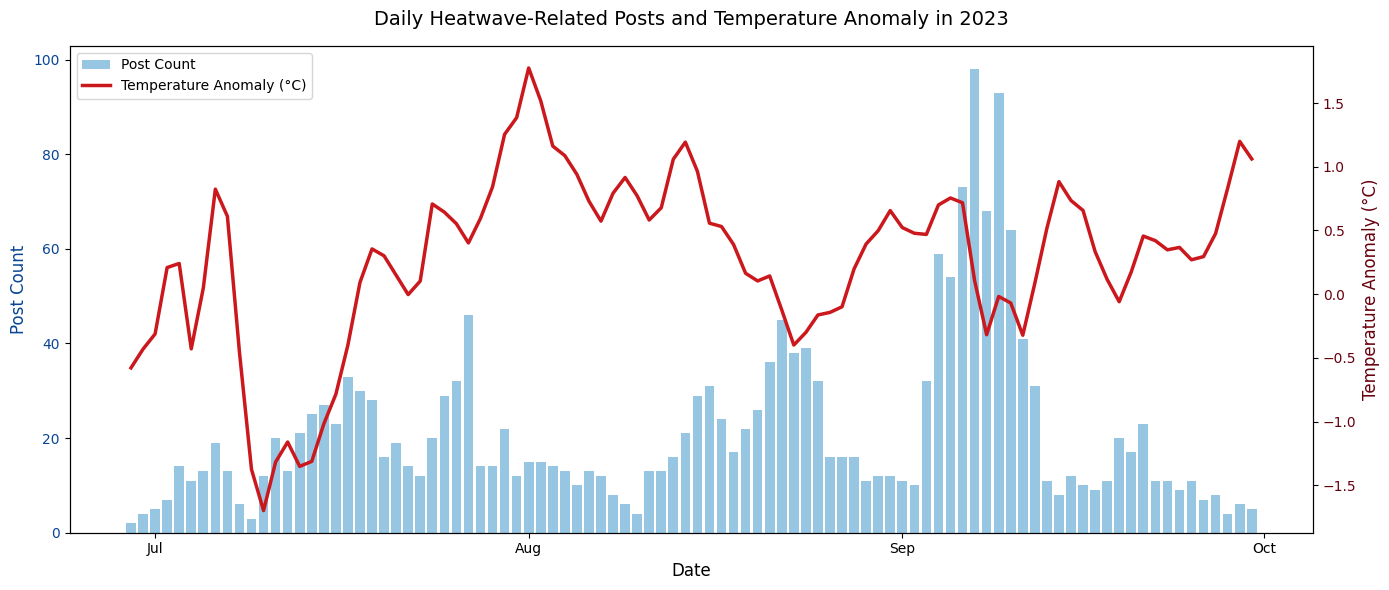

📌 Pearson Correlation (same day): -0.11
📌 Pearson Correlation (lag +1 day): -0.09

📊 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.056
Date:                Fri, 25 Apr 2025   Prob (F-statistic):              0.307
Time:                        00:27:12   Log-Likelihood:                -404.59
No. Observations:                  94   AIC:                             813.2
Df Residuals:                      92   BIC:                             818.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------

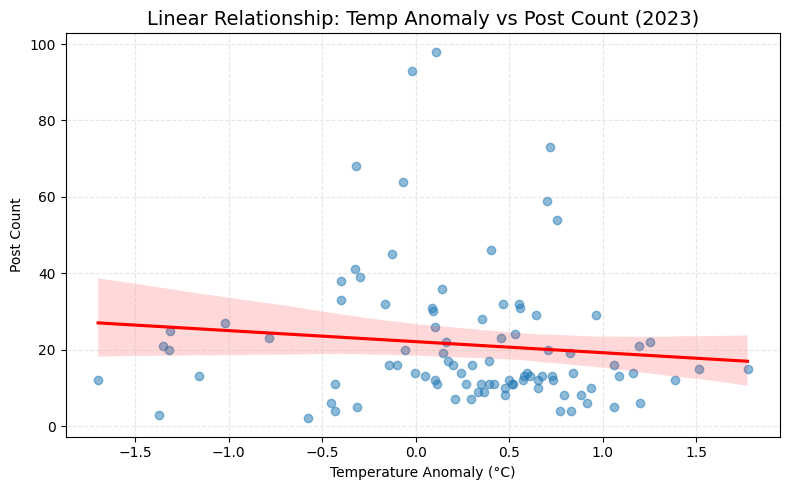

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

temp_df = pd.read_csv('/content/lsm2023.csv')
posts_df = pd.read_json('/content/heat_posts2023.jsonl', lines=True)

temp_df['date'] = pd.to_datetime('2023-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df = temp_df[['date', 'temp_anomaly']]
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')

posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

merged_df = pd.merge(posts_daily, temp_df, on='date', how='inner')


fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(merged_df['date'], merged_df['post_count'],
        color='#6baed6', alpha=0.7, label='Post Count')
ax1.set_ylabel('Post Count', fontsize=12, color='#084594')
ax1.tick_params(axis='y', labelcolor='#084594')
ax1.set_xlabel('Date', fontsize=12)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=0, fontsize=10)

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['temp_anomaly'],
         color='#cb181d', linewidth=2.5, label='Temperature Anomaly (°C)')
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, color='#67000d')
ax2.tick_params(axis='y', labelcolor='#67000d')
plt.title('Daily Heatwave-Related Posts and Temperature Anomaly in 2023', fontsize=14, pad=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

temp_df = pd.read_csv('/content/lsm2023.csv')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df['date'] = pd.to_datetime('2023-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')
temp_df = temp_df[['date', 'temp_anomaly']].dropna()

posts_df = pd.read_json('/content/heat_posts2023.jsonl', lines=True)
posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

df = pd.merge(posts_daily, temp_df, on='date', how='inner')
df = df.dropna()

# 1. Pearson correlation
corr = df['temp_anomaly'].corr(df['post_count'])
print(f"📌 Pearson Correlation (same day): {corr:.2f}")

# 2.Lag time
df['post_count_lag1'] = df['post_count'].shift(-1)
lag_corr = df[['temp_anomaly', 'post_count_lag1']].corr().iloc[0, 1]
print(f"📌 Pearson Correlation (lag +1 day): {lag_corr:.2f}")

# 3. Linear relationship
X = sm.add_constant(df['temp_anomaly'])
y = df['post_count']
model = sm.OLS(y, X).fit()

print("\n📊 Regression Summary:")
print(model.summary())

plt.figure(figsize=(8, 5))
sns.regplot(x='temp_anomaly', y='post_count', data=df,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Linear Relationship: Temp Anomaly vs Post Count (2023)', fontsize=14)
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Post Count')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

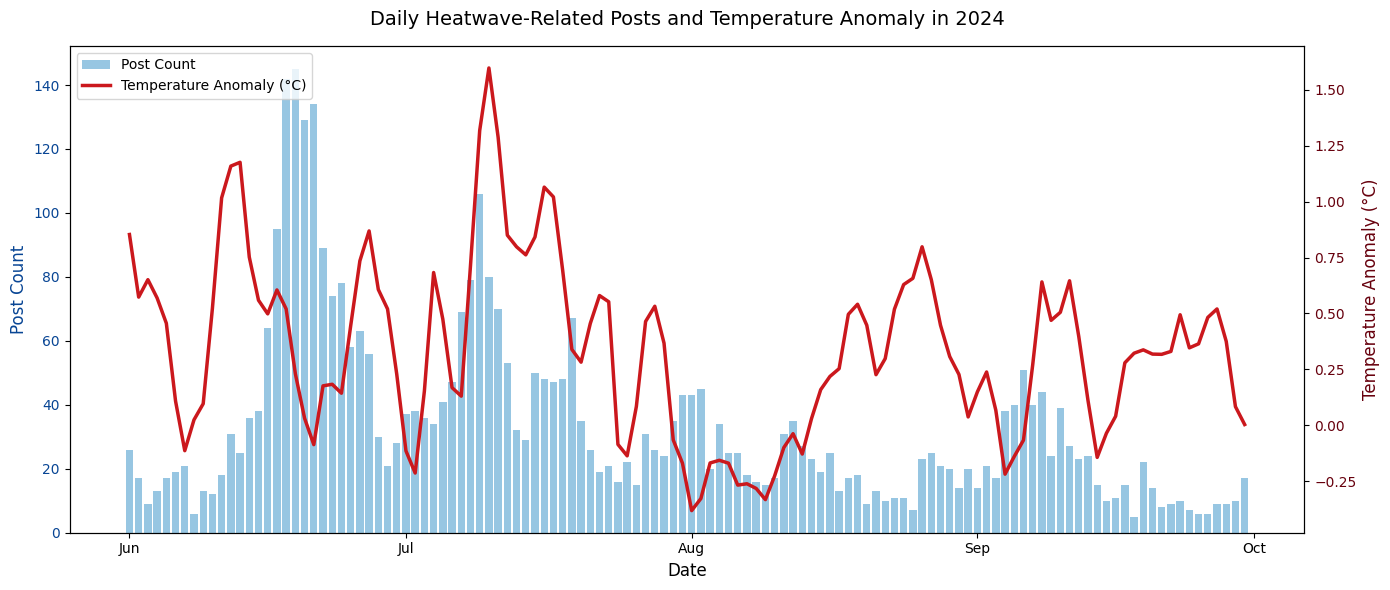

📌 Pearson Correlation (same day): 0.15
📌 Pearson Correlation (lag +1 day): 0.15

📊 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.799
Date:                Sat, 26 Apr 2025   Prob (F-statistic):             0.0969
Time:                        21:13:17   Log-Likelihood:                -578.11
No. Observations:                 122   AIC:                             1160.
Df Residuals:                     120   BIC:                             1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

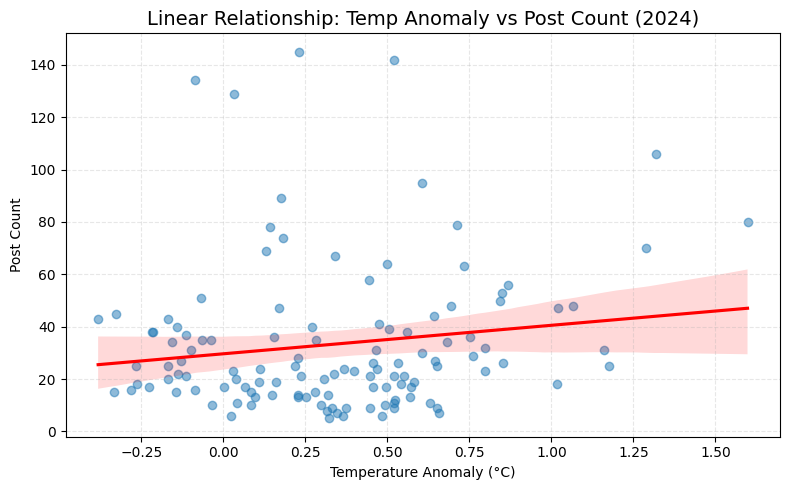

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

temp_df = pd.read_csv('/content/lsm2024.csv')
posts_df = pd.read_json('/content/heat_posts2024_standardized.jsonl', lines=True)

temp_df['date'] = pd.to_datetime('2024-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df = temp_df[['date', 'temp_anomaly']]
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')

posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

merged_df = pd.merge(posts_daily, temp_df, on='date', how='inner')


fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(merged_df['date'], merged_df['post_count'],
        color='#6baed6', alpha=0.7, label='Post Count')
ax1.set_ylabel('Post Count', fontsize=12, color='#084594')
ax1.tick_params(axis='y', labelcolor='#084594')
ax1.set_xlabel('Date', fontsize=12)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=0, fontsize=10)

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['temp_anomaly'],
         color='#cb181d', linewidth=2.5, label='Temperature Anomaly (°C)')
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, color='#67000d')
ax2.tick_params(axis='y', labelcolor='#67000d')
plt.title('Daily Heatwave-Related Posts and Temperature Anomaly in 2024', fontsize=14, pad=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

temp_df = pd.read_csv('/content/lsm2024.csv')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df['date'] = pd.to_datetime('2024-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')
temp_df = temp_df[['date', 'temp_anomaly']].dropna()

posts_df = pd.read_json('/content/heat_posts2024_standardized.jsonl', lines=True)
posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

df = pd.merge(posts_daily, temp_df, on='date', how='inner')
df = df.dropna()

# 1. Pearson correlation
corr = df['temp_anomaly'].corr(df['post_count'])
print(f"📌 Pearson Correlation (same day): {corr:.2f}")

# 2.Lag time
df['post_count_lag1'] = df['post_count'].shift(-1)
lag_corr = df[['temp_anomaly', 'post_count_lag1']].corr().iloc[0, 1]
print(f"📌 Pearson Correlation (lag +1 day): {lag_corr:.2f}")

# 3. Linear relationship
X = sm.add_constant(df['temp_anomaly'])
y = df['post_count']
model = sm.OLS(y, X).fit()

print("\n📊 Regression Summary:")
print(model.summary())

plt.figure(figsize=(8, 5))
sns.regplot(x='temp_anomaly', y='post_count', data=df,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Linear Relationship: Temp Anomaly vs Post Count (2024)', fontsize=14)
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Post Count')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

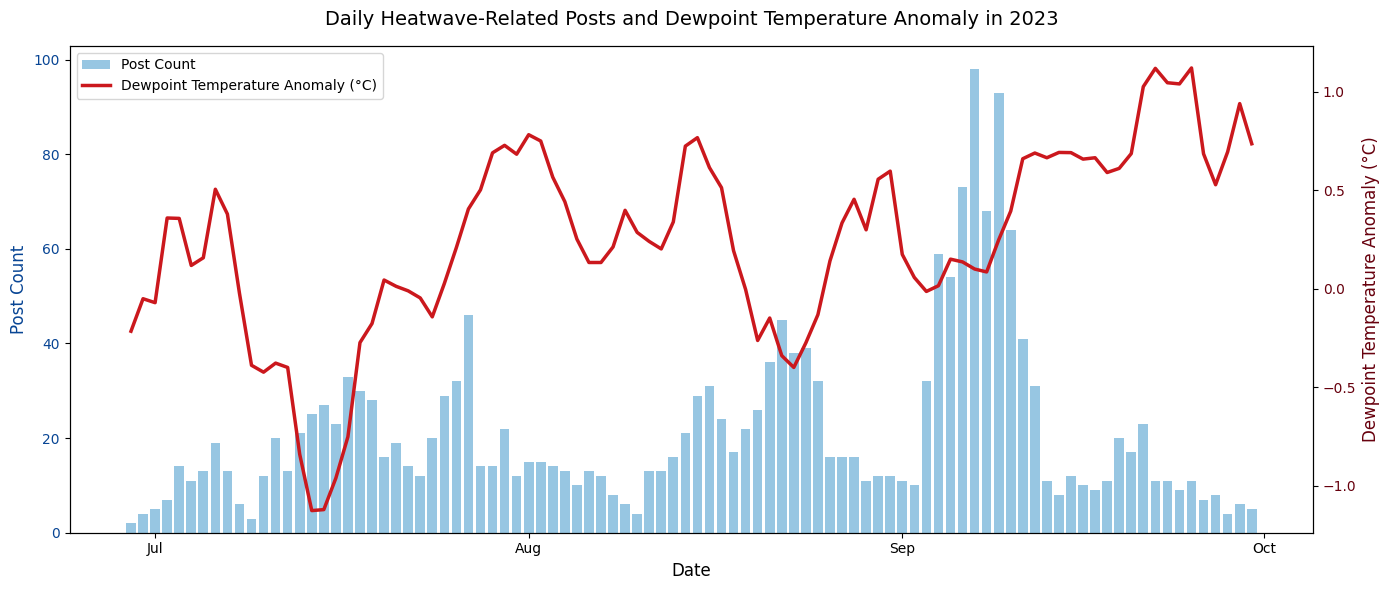

📌 Pearson Correlation (same day): -0.20
📌 Pearson Correlation (lag +1 day): -0.28

📊 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.982
Date:                Fri, 25 Apr 2025   Prob (F-statistic):             0.0490
Time:                        00:33:10   Log-Likelihood:                -403.14
No. Observations:                  94   AIC:                             810.3
Df Residuals:                      92   BIC:                             815.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------

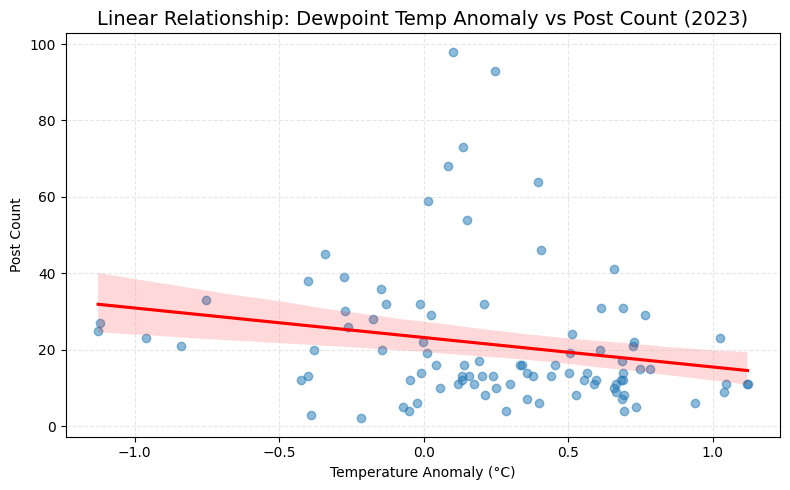

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

temp_df = pd.read_csv('/content/2023dewpoint-temperature.csv')
posts_df = pd.read_json('/content/heat_posts2023.jsonl', lines=True)

temp_df['date'] = pd.to_datetime('2023-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df = temp_df[['date', 'temp_anomaly']]
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')

posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

merged_df = pd.merge(posts_daily, temp_df, on='date', how='inner')


fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(merged_df['date'], merged_df['post_count'],
        color='#6baed6', alpha=0.7, label='Post Count')
ax1.set_ylabel('Post Count', fontsize=12, color='#084594')
ax1.tick_params(axis='y', labelcolor='#084594')
ax1.set_xlabel('Date', fontsize=12)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=0, fontsize=10)

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['temp_anomaly'],
         color='#cb181d', linewidth=2.5, label='Dewpoint Temperature Anomaly (°C)')
ax2.set_ylabel('Dewpoint Temperature Anomaly (°C)', fontsize=12, color='#67000d')
ax2.tick_params(axis='y', labelcolor='#67000d')
plt.title('Daily Heatwave-Related Posts and Dewpoint Temperature Anomaly in 2023', fontsize=14, pad=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

temp_df = pd.read_csv('/content/2023dewpoint-temperature.csv')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df['date'] = pd.to_datetime('2023-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')
temp_df = temp_df[['date', 'temp_anomaly']].dropna()

posts_df = pd.read_json('/content/heat_posts2023.jsonl', lines=True)
posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

df = pd.merge(posts_daily, temp_df, on='date', how='inner')
df = df.dropna()

# 1. Pearson correlation
corr = df['temp_anomaly'].corr(df['post_count'])
print(f"📌 Pearson Correlation (same day): {corr:.2f}")

# 2.Lag time
df['post_count_lag1'] = df['post_count'].shift(-1)
lag_corr = df[['temp_anomaly', 'post_count_lag1']].corr().iloc[0, 1]
print(f"📌 Pearson Correlation (lag +1 day): {lag_corr:.2f}")

# 3. Linear relationship
X = sm.add_constant(df['temp_anomaly'])
y = df['post_count']
model = sm.OLS(y, X).fit()

print("\n📊 Regression Summary:")
print(model.summary())

plt.figure(figsize=(8, 5))
sns.regplot(x='temp_anomaly', y='post_count', data=df,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Linear Relationship: Dewpoint Temp Anomaly vs Post Count (2023)', fontsize=14)
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Post Count')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

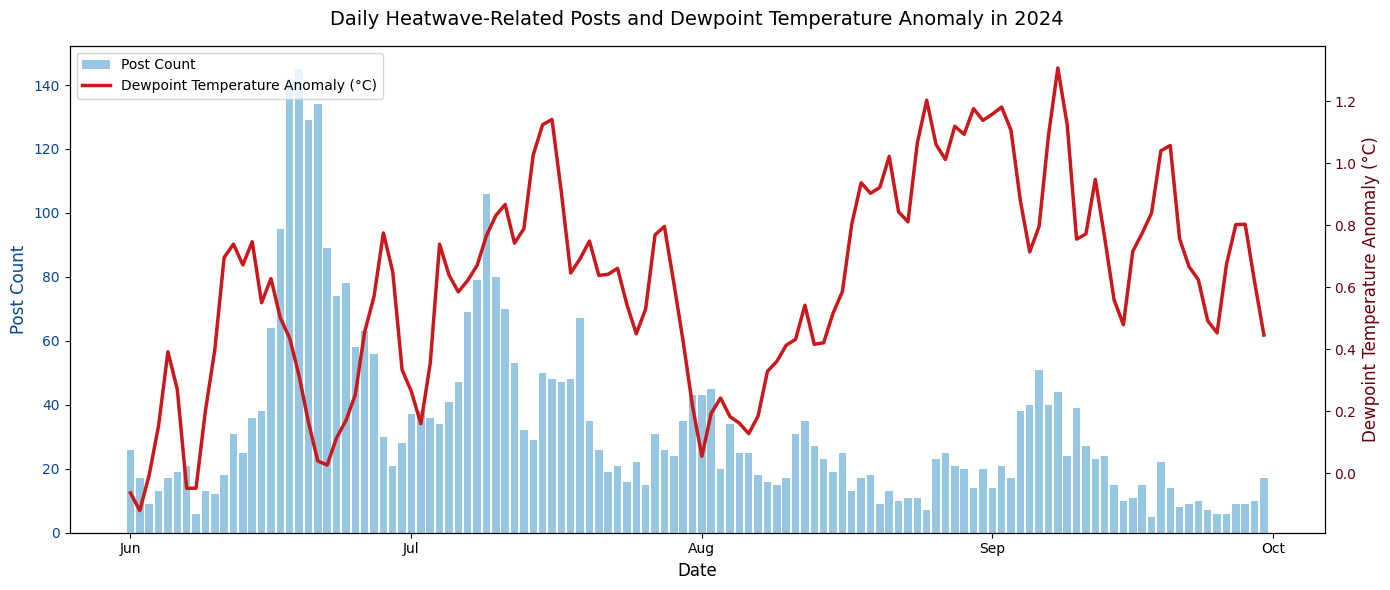

📌 Pearson Correlation (same day): -0.20
📌 Pearson Correlation (lag +1 day): -0.16

📊 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.239
Date:                Fri, 25 Apr 2025   Prob (F-statistic):             0.0238
Time:                        00:35:02   Log-Likelihood:                -576.91
No. Observations:                 122   AIC:                             1158.
Df Residuals:                     120   BIC:                             1163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------

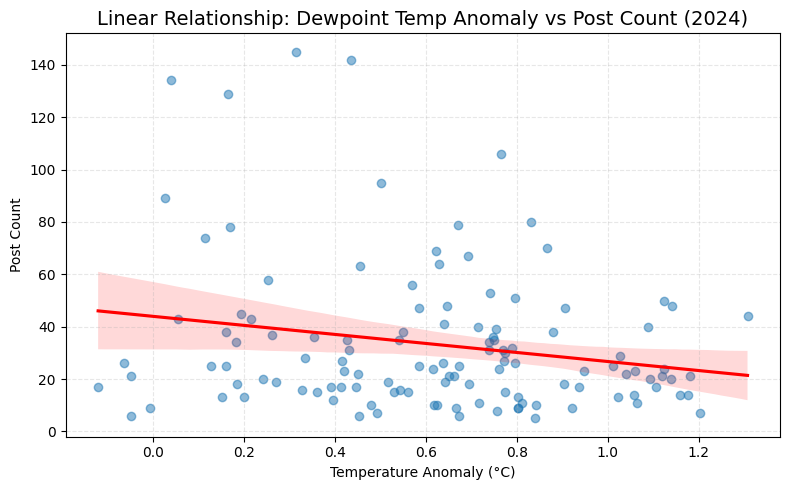

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

temp_df = pd.read_csv('/content/2024 dewpoint-temperature.csv')
posts_df = pd.read_json('/content/heat_posts2024_standardized.jsonl', lines=True)

temp_df['date'] = pd.to_datetime('2024-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df = temp_df[['date', 'temp_anomaly']]
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')

posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

merged_df = pd.merge(posts_daily, temp_df, on='date', how='inner')


fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(merged_df['date'], merged_df['post_count'],
        color='#6baed6', alpha=0.7, label='Post Count')
ax1.set_ylabel('Post Count', fontsize=12, color='#084594')
ax1.tick_params(axis='y', labelcolor='#084594')
ax1.set_xlabel('Date', fontsize=12)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=0, fontsize=10)

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['temp_anomaly'],
         color='#cb181d', linewidth=2.5, label='Dewpoint Temperature Anomaly (°C)')
ax2.set_ylabel('Dewpoint Temperature Anomaly (°C)', fontsize=12, color='#67000d')
ax2.tick_params(axis='y', labelcolor='#67000d')
plt.title('Daily Heatwave-Related Posts and Dewpoint Temperature Anomaly in 2024', fontsize=14, pad=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

temp_df = pd.read_csv('/content/2024 dewpoint-temperature.csv')
temp_col = [col for col in temp_df.columns if 'temperature' in col.lower()][0]
temp_df = temp_df.rename(columns={temp_col: 'temp_anomaly'})
temp_df['date'] = pd.to_datetime('2024-' + temp_df['Month-Day'], format='%Y-%m-%d')
temp_df['temp_anomaly'] = pd.to_numeric(temp_df['temp_anomaly'], errors='coerce')
temp_df = temp_df[['date', 'temp_anomaly']].dropna()

posts_df = pd.read_json('/content/heat_posts2024_standardized.jsonl', lines=True)
posts_df['date'] = pd.to_datetime(posts_df['created_at']).dt.date
posts_daily = posts_df.groupby('date').size().reset_index(name='post_count')
posts_daily['date'] = pd.to_datetime(posts_daily['date'])

df = pd.merge(posts_daily, temp_df, on='date', how='inner')
df = df.dropna()

# 1. Pearson correlation
corr = df['temp_anomaly'].corr(df['post_count'])
print(f"📌 Pearson Correlation (same day): {corr:.2f}")

# 2.Lag time
df['post_count_lag1'] = df['post_count'].shift(-1)
lag_corr = df[['temp_anomaly', 'post_count_lag1']].corr().iloc[0, 1]
print(f"📌 Pearson Correlation (lag +1 day): {lag_corr:.2f}")

# 3. Linear relationship
X = sm.add_constant(df['temp_anomaly'])
y = df['post_count']
model = sm.OLS(y, X).fit()

print("\n📊 Regression Summary:")
print(model.summary())

plt.figure(figsize=(8, 5))
sns.regplot(x='temp_anomaly', y='post_count', data=df,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Linear Relationship: Dewpoint Temp Anomaly vs Post Count (2024)', fontsize=14)
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Post Count')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()